In [2]:
from new_model import *
from Graphing import *
patches_all[0]

c:\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


'10.4'

In [16]:

odds_data = pd.read_csv(data_dir + pro_csvs_dir + 'odds.csv', index_col=0)

In [18]:
1287256 in odds_data.index

True

In [2]:
np.mean([val[0] for val in run_ps.values()])

0.7435436438883571

In [35]:
op_gcs, ch_gcs, ch_gms = None, None, None
# def load_global_stats(n_load=n_gsdb_load, by_patches=False, n_patches=np.inf, oldest_patch=-np.inf, load_max=9999):
# def load_global_stats(
n_load=n_gsdb_load
by_patches=True
n_patches=n_gsdb_patches
oldest_patch=-np.inf
load_max=9999
del_old=False
op_gcs, ch_gcs, ch_gms = None, None, None

pr_fl("Loading global champion & matchup stats databases...")
oc = sorted(glob.glob(data_dir + r_cache["opgg_stats"]["path"]  +  "/*.json"))[::-1]#[:n_load]
cc_ = sorted(glob.glob(data_dir + r_cache["chgg_champions"]["path"] + "/*.json"))[::-1]
cm_ = sorted(glob.glob(data_dir + r_cache["chgg_matchups"]["path"]  + "/*.json"))[::-1]
cc_df = [deglob_fn(fn, '.json') for fn in cc_]
cm_df = [deglob_fn(fn, '.json') for fn in cm_]

old_oc = oc[n_load:]
oc = oc[:n_load]
old_cc, old_cm = [], []

if by_patches:
    cc, cm = [], []
    cc_patches, cm_patches = [], []
    for i in range(len(cc_df)):
        fn = cc_df[i]
        patch = patch_s2n(fn.split('_')[1])
        if patch < oldest_patch:
            old_cc += cc_[i:]
            break
        if patch not in cc_patches:
            cc_patches.append(patch)
            cc.append(cc_[cc_df.index(fn)])
            if len(cc) >= min(n_patches, load_max):
                old_cc += cc_[i + 1:]
                break
            continue
        old_cc.append(cc_[i])

    for i in range(len(cm_df)):
        fn = cm_df[i]
        patch = patch_s2n(fn.split('_')[1])
        if patch < oldest_patch:
            old_cm += cm_[i:]
            break
        if patch not in cm_patches:
            cm_patches.append(patch)
            cm.append(cm_[cm_df.index(fn)])
            if len(cm) >= min(n_patches, load_max):
                old_cm += cm_[i + 1:]
                break
            continue
        old_cm.append(cm_[i])

else:
    cc = cc_
    cm = cm_

if del_old:  # Delete older or redundant stats
    for fn in old_oc + old_cc + old_cm:
        if os.path.exists(fn):
            os.remove(fn)

op_gcs_libs = [load_json(path, pad=False, print_errs=True) for path in oc]
ch_gcs_libs = [load_json(path, pad=False, print_errs=True) for path in cc]
ch_gms_libs = [load_json(path, pad=False, print_errs=True) for path in cm]

op_gcs_tss = [int(deglob_fn(path, '.json').split('_')[0]) for path in oc]
ch_gcs_tss = [int(deglob_fn(path, '.json').split('_')[0]) for path in cc]
ch_gms_tss = [int(deglob_fn(path, '.json').split('_')[0]) for path in cm]
op_gcs, ch_gcs, ch_gms = [OrderedDict() for _ in range(3)]

for i in range(len(oc)):  # op.gg Global champion stats
    op_gcs_lib = op_gcs_libs[i]
    # old_euw_only_data = False
    # if len(op_gcs_lib) != len(opgg_regions):
    #     old_euw_only_data = True
    op_gcs_i = {}

    if len(op_gcs_lib) > len(opgg_regions):
        id_ind = opgg_regions_old.index('id')
        op_gcs_lib = op_gcs_lib[:id_ind] + op_gcs_lib[id_ind + 1:]

    for r in range(len(op_gcs_lib)):
        # if old_euw_only_data:
        #     if r != 0:
        #         break
        #     op_gcs_r = op_gcs_lib
        #     reg = 'euw'
        # else:
        op_gcs_r = op_gcs_lib[r]
        reg = opgg_regions[r]
        op_gcs_i[reg] = []

        # Correct pre-Iron data
        if len(op_gcs_r) < len(opgg_elos):
            op_gcs_r = op_gcs_r[:1] + [op_gcs_r[1]] + op_gcs_r[1:-1] + [op_gcs_r[-2]] + op_gcs_r[-1:]

        for e in range(len(opgg_elos)):
            op_gcs_e = op_gcs_r[e]
            op_gcs_i[reg].append({})
            for p in range(len(opgg_periods)):
                op_gcs_p = op_gcs_e[p]
                per = opgg_periods[p]
                op_gcs_i[reg][-1][per] = {}
                for t in range(len(opgg_types)):
                    op_gcs_t = op_gcs_p[t]
                    typ = opgg_types[t]
                    op_gcs_i[reg][-1][per][typ] = {}
                    # if len(op_gcs_t) == 0:
                    #     pr_fl(i, oc[i], opgg_regions[r], opgg_elos[e], \
                    #             opgg_periods[p], opgg_types[t])
                    #     continue
                    # if type(op_gcs_t[0]) is list: # Weird bug?
                    #     pr_fl(i, oc[i], opgg_regions[r], opgg_elos[e], \
                    #         opgg_periods[p], opgg_types[t], c, \
                    #         len(op_gcs_t), len(op_gcs_t[0]))
                    #         # pr_fl(op_gcs_c)
                    #     op_gcs_t = op_gcs_t[0]
                    cis, counts = [], []
                    for c in range(len(op_gcs_t)):
                        op_gcs_c = op_gcs_t[c]
                        counts.append(op_gcs_c['games'])
                        op_name = op_gcs_c['name']
                        if op_name == "Nunu":
                            op_name = "Nunu & Willump"
                        # if op_name == "Yuumi":
                        #     op_name = "Ezreal"
                        cid = champ_dict[op_name]
                        cis.append(cid)
                        op_gcs_i[reg][-1][per][typ][cid] = op_gcs_c
                    s = sum(counts)
                    for c in range(len(cis)):
                        op_gcs_i[reg][-1][per][typ][cis[c]]['gamesFrac']=\
                            counts[c] / s
                        # Temporary fix for missing kda values
                        if op_gcs_i[reg][-1][per][typ][cis[c]]['kda'] is None:
                            op_gcs_i[reg][-1][per][typ][cis[c]]['kda'] = 2.5
    op_gcs[op_gcs_tss[i]] = op_gcs_i

 2020-01-31 11:17:46 Loading global champion & matchup stats databases...


In [47]:
op_gcs[list(op_gcs.keys())[0]]["euw"][-1]["month"]["win"][champ_dict["Sett"]]

{'rank': 74,
 'name': 'Sett',
 'winrate': 54.46,
 'games': 325,
 'kda': 2.44,
 'cs': 175.92,
 'gold': 10910,
 'gamesFrac': 0.01688925843163748}

In [33]:
opgs = load_json("opgg_cache/stats/1580381178527_10.2", print_errs=True)
[[a for a in opgs[i][-1][2][0] if a["name"] == "Sett"] for i in range(len(opgs))]

[[{'rank': 87,
   'name': 'Sett',
   'winrate': 46.67,
   'games': 75,
   'kda': 2.04,
   'cs': 172.44,
   'gold': 10634}],
 [{'rank': 30,
   'name': 'Sett',
   'winrate': 71.43,
   'games': 28,
   'kda': 2.43,
   'cs': 173.25,
   'gold': 10873}],
 [{'rank': 64,
   'name': 'Sett',
   'winrate': 54.24,
   'games': 118,
   'kda': 2.83,
   'cs': 168.65,
   'gold': 10596}],
 [{'rank': 20,
   'name': 'Sett',
   'winrate': 72.41,
   'games': 29,
   'kda': 2.4,
   'cs': 191.07,
   'gold': 11060}],
 [{'rank': 32,
   'name': 'Sett',
   'winrate': 58.33,
   'games': 12,
   'kda': 2.76,
   'cs': 187.5,
   'gold': 12382}],
 [{'rank': 65,
   'name': 'Sett',
   'winrate': 53.03,
   'games': 66,
   'kda': 2.36,
   'cs': 157.91,
   'gold': 10377}],
 [{'rank': 50,
   'name': 'Sett',
   'winrate': 50,
   'games': 8,
   'kda': 2.86,
   'cs': 200.75,
   'gold': 12285}],
 [{'rank': 50,
   'name': 'Sett',
   'winrate': 62.5,
   'games': 40,
   'kda': 2.49,
   'cs': 180.88,
   'gold': 10849}],
 [{'rank': 19,

In [32]:
opgs = load_json("opgg_cache/stats/1568166299690_9.17", print_errs=True)
[[a for a in opgs[i][-1][2][0] if a["name"] == "Rumble"] for i in range(len(opgs))]

[[{'rank': 86,
   'name': 'Rumble',
   'winrate': 50,
   'games': 4,
   'kda': 1.11,
   'cs': 123.5,
   'gold': 6725}],
 [],
 [{'rank': 70,
   'name': 'Rumble',
   'winrate': 47.83,
   'games': 23,
   'kda': 2.15,
   'cs': 153.09,
   'gold': 9188}],
 [],
 [],
 [{'rank': 42,
   'name': 'Rumble',
   'winrate': 60,
   'games': 5,
   'kda': 2.22,
   'cs': 150.2,
   'gold': 8588}],
 [],
 [{'rank': 54,
   'name': 'Rumble',
   'winrate': 50,
   'games': 6,
   'kda': 2.36,
   'cs': 125.17,
   'gold': 10179}],
 [{'rank': 17,
   'name': 'Rumble',
   'winrate': 100,
   'games': 1,
   'kda': 2.33,
   'cs': 171,
   'gold': 11326}],
 [],
 [{'rank': 92,
   'name': 'Rumble',
   'winrate': 0,
   'games': 2,
   'kda': 1.87,
   'cs': 191.5,
   'gold': 12043}],
 [],
 [],
 [],
 [],
 [],
 []]

[[{'rank': 59,
   'name': 'Rumble',
   'winrate': 52.94,
   'games': 34,
   'kda': 2.49,
   'cs': 161.71,
   'gold': 10184}],
 [{'rank': 56,
   'name': 'Rumble',
   'winrate': 60,
   'games': 20,
   'kda': 3.29,
   'cs': 171.5,
   'gold': 11744}],
 [{'rank': 72,
   'name': 'Rumble',
   'winrate': 52.56,
   'games': 78,
   'kda': 2.25,
   'cs': 114.49,
   'gold': 8752}],
 [{'rank': 45,
   'name': 'Rumble',
   'winrate': 55.56,
   'games': 27,
   'kda': 3.05,
   'cs': 151.89,
   'gold': 10701}],
 [{'rank': 37,
   'name': 'Rumble',
   'winrate': 50,
   'games': 6,
   'kda': 3.7,
   'cs': 190.33,
   'gold': 11314}],
 [{'rank': 36,
   'name': 'Rumble',
   'winrate': 63.64,
   'games': 22,
   'kda': 2.39,
   'cs': 133.55,
   'gold': 9632}],
 [],
 [{'rank': 75,
   'name': 'Rumble',
   'winrate': 55.56,
   'games': 9,
   'kda': 2.86,
   'cs': 149.11,
   'gold': 10125}],
 [{'rank': 31,
   'name': 'Rumble',
   'winrate': 62.5,
   'games': 8,
   'kda': 2.3,
   'cs': 179.25,
   'gold': 11838}],
 [

In [3]:
Meta_, X_, X_rec, Yc_, Yr_, (meta_labels, X_labels, X_rec_labels, Yc_labels, Yr_labels) = \
    load_ld(store_folder + "d_all__unf.data", pad=False)

In [24]:
filler = load_json("infill_data/infill_data", print_errs=True)

In [4]:
X_label_is = dict(zip(X_labels, range(len(X_labels))))
X_rec_label_is = dict(zip(X_rec_labels, range(len(X_rec_labels))))

In [6]:
fill = filler["fill"]
pr_fl("Infilling before save...")
fl_i, max_fl = 0, str(len(filler["flags"]))
for flag in filler["flags"]:
    val = fill
    key_i = -1
    for key in flag[3:]:
        key_i += 1

        if isinstance(val, dict) and key not in val:

            if str(key) in val:
                key = str(key)
            else:

                if val["_name"] == "div": # If we don't yet have data for master+
                    key = int(key)
                    if key >= 25:
                        key = 24
                    if key not in val and str(key) not in val:
                        if key >= 24:
                            key = 23
                    if key not in val:
                        key = str(key)

#             if key not in val:
#                 if 
                
            if key not in val:
                if val['_name'] == 'cid':
                    if int(key) == champ_dict["Sett"]:
                        key = champ_dict["Jax"]
                    elif int(key) == champ_dict["Senna"]:
                        key = champ_dict["Pyke"]
                    elif int(key) == champ_dict["Aphelios"]:
                        key = champ_dict["Jhin"]
#                     elif int(key) == champ_dict["Rumble"]:
#                         key = champ_dict["Vladimir"]
            if key not in val and str(key) in val:
                key = str(key)

            if key not in val:
                pr_fl("Infill error:", flag, key, val.keys(), val["_name"])

        val = val[key]
    X_[flag[0], X_label_is[flag[2]]] = val["_data"]
    fl_i += 1
    if fl_i % 1000 == 0:
        sys_print("\rFill flag # " + str(fl_i) + '/' + max_fl)

 2020-03-04 17:21:35 Infilling before save...
Fill flag # 357000/357667

In [29]:
pr_fl("Rolling fill...")
fl_i, max_fl = 0, str(len(filler["rec_flags"]))
for flag in filler["rec_flags"]:
    flag = deepcopy(flag)
    val = fill
    if flag[0] == 5210 and flag[1] == 7 and flag[2] == 3:
        print(flag)
#         flag == [5210, 7, 3, 'opgg_champion_recent_max_kills', 'opgg_champion_recent_max_kills', 0, 42]:
#         flag[5] = 1
    if flag == [5210, 7, 3, 'opgg_champion_recent_max_kills', 'opgg_champion_recent_max_kills', 0, 42]:
        flag[5] = 1
    if flag == [5210, 7, 3, 'opgg_champion_recent_max_deaths', 'opgg_champion_recent_max_deaths', 0, 42]:
        flag[5] = 1
    if flag == [5210, 7, 3, 'opgg_champion_season_max_kills', 'opgg_champion_season_max_kills', 0, 42]:
        flag[5] = 1
    if flag == [5210, 7, 3, 'opgg_champion_season_max_deaths', 'opgg_champion_season_max_deaths', 0, 42]:
        flag[5] = 1
    fkey_i = 4
    for key in flag[4:]:
        fkey_i += 1

        if isinstance(val, dict) and "_name" in val and val["_name"] == 'div' and \
          fkey_i + 1 < len(flag) and "_name" in val[key] and \
          val[key]["_name"] == 'cid' and flag[fkey_i + 1] not in val[key]:
            pr_fl("Infill error, rotating elo:", flag, flag[fkey_i + 1], val[key].keys(), val[key]["_name"])
            pr_fl("Old div:", key)
            while flag[fkey_i + 1] not in val[key]:
                key -= 1
                if key < 0:
                    key = 26
            pr_fl("New div:", key)

        if isinstance(val, dict) and key not in val:

            if str(key) in val:
                key = str(key)
            else:

                if val["_name"] == "div": # If we don't yet have data for master+
                    key = int(key)
                    if key >= 25:
                        key = 24
                    if key not in val and str(key) not in val:
                        if key >= 24:
                            key = 23
                    if key not in val:
                        key = str(key)

                if key not in val:
                    if val['_name'] == 'cid':
                        if int(key) == champ_dict["Sett"]:
                            key = champ_dict["Jax"]
                        elif int(key) == champ_dict["Senna"]:
                            key = champ_dict["Pyke"]
                        elif int(key) == champ_dict["Aphelios"]:
                            key = champ_dict["Jhin"]
                        elif int(key) == champ_dict["Rumble"]:
                            key = champ_dict["Vladimir"]
                if key not in val and str(key) in val:
                    key = str(key)

                if key not in val:
                    pr_fl("Infill error:", flag, key, val.keys(), val["_name"], len(val.keys()))

        val = val[key]
    X_rec[flag[0]][flag[1]][flag[2], X_rec_label_is[flag[3]]] = \
            val["_data"]
    fl_i += 1
    if fl_i % 100 == 0:
        sys_print("\rFill flag # " + str(fl_i) + '/' + max_fl)

res = [Meta_, X_, X_rec, Yc_, Yr_]
res.append([meta_labels, X_labels, X_rec_labels, Yc_labels, Yr_labels])
save_ld(res, store_folder + 'd_all_current.data', pad=False)

 2020-03-04 17:47:04 Rolling fill...
Fill flag # 190900/357667[5210, 7, 3, 'opgg_champion_recent_max_kills', 'opgg_champion_recent_max_kills', 0, 42]
[5210, 7, 3, 'opgg_champion_recent_max_deaths', 'opgg_champion_recent_max_deaths', 0, 42]
[5210, 7, 3, 'opgg_champion_season_max_kills', 'opgg_champion_season_max_kills', 0, 42]
[5210, 7, 3, 'opgg_champion_season_max_deaths', 'opgg_champion_season_max_deaths', 0, 42]
Fill flag # 1406500/357667

In [9]:
a = [
#     0.05951284395788444,
#     0.007000000000000001,
#     0.0567980386704668,
#     0.15,
#     0.10547214420113397,
#     0.07312838249906625,
#     0.007000000000000001,
#     0.08770650058086565,
#     0.15,
#     0.11516367038826665,
#     0.04813636164248709,
    0.5096 / 10.0,
    0.6274 / 10.0,
    0.01 / 10.0,
    0.8393 / 10.0,
    1.311 / 10.0,
    0.1502 / 10.0,
    0.4048 / 10.0,
    0.4482 / 10.0,
#     0.11465920112854736,
]
np.mean(a), len(a)

(0.053756250000000005, 8)

In [10]:
b = [
#     0.5,
#     0.5,
#     0.5,
#     0.20000000000000004,
#     0.5,
#     0.20000000000000004,
#     0.5,
#     0.39220143150999065,
#     0.5,
#     0.40460592500867626,
#     0.3362872662629863,
    0.7147 / 3.0,
    0.6109 / 3.0,
    1.5 / 3.0,
    1.051 / 3.0,
    1.5 / 3.0,
    1.294 / 3.0,
    1.5 / 3.0,
    0.7475 / 3.0,
#     0.20000000000000004,
]
np.mean(b), len(b)

(0.37158749999999996, 8)

In [11]:
g = [
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
#     0.007000000000000001,
    0.04555 / 10.0,
    0.04156 / 10.0,
    0.01 / 10.0,
    0.02617 / 10.0,
    0.04049 / 10.0,
    0.01 / 10.0,
    0.2232 / 10.0,
    0.08361 / 10.0,
#     0.007000000000000001,
]
np.mean(g), len(g)

(0.00600725, 8)

In [2]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = \
    load_ld("H:\Code\lolorb\data\learning_data\d_all__unf.data", pad=False)

In [17]:
meta, X, meta_labels, X_labels = clean_features(meta, X, meta_labels, X_labels)
X, X_labels = filter_linearonly(X, X_labels)
X, X_labels = filter_features(X, X_labels)

In [4]:
max(X[:, X_labels.index("blue_top_opgg_champion_avg_kills")])

nan

In [20]:
nanlocs = np.isnan(X)
nonzeros = np.nonzero(nanlocs)
nanrows = list(set(nonzeros[0]))
100 * len(nanrows) / len(X)

13.3825

In [ ]:
meta, X, X_rec, Yc, Yr = remove_data_inds(meta, X, X_rec, Yc, Yr, data_del)

In [32]:
d = load_json("chgg_cache/matchups/1579941680449_10.2")

In [45]:
d["875"] = d["24"]

In [46]:
save_json(d, "chgg_cache/matchups/1579941680449_10.2")

In [43]:
champ_dict["Senna"], champ_dict["Aphelios"], champ_dict["Sett"], champ_dict["Jax"]

(235, 523, 875, 24)

In [41]:
n_runs = 5
n_folds = 5
all_inds = []
for i in range(n_runs):
    inds = np.arange(87743)
    np.random.shuffle(inds)
    splitter = StratifiedKFold(n_splits=5)
    folds = []
    for train_idx, test_idx in splitter.split(X):
        folds.append((train_idx, test_idx))
    all_inds.append(folds)
save_ld(all_inds, "model_logs/cv_idx.data", pad=False)

TypeError: split() missing 1 required positional argument: 'y'

In [32]:
np.arange(5)[[4,3,1,2,0]][np.argsort([4,3,1,2,0])]

array([0, 1, 2, 3, 4])

In [5]:
X_labels_al, X_rec_labels_al, X_alphas, X_betas, X_gammas, X_rec_alphas, X_rec_betas, X_rec_gammas = \
        load_ld("model_logs/AutoLogTransf.data", pad=False)
X_alphas_dict = dict(zip(X_labels_al, X_alphas))
X_betas_dict = dict(zip(X_labels_al, X_betas))
X_gammas_dict = dict(zip(X_labels_al, X_gammas))
X_rec_alphas_dict = [dict(zip(X_rec_labels_al, X_rec_alphas[i])) for i in range(5)]
X_rec_betas_dict = [dict(zip(X_rec_labels_al, X_rec_betas[i])) for i in range(5)]
X_rec_gammas_dict = [dict(zip(X_rec_labels_al, X_rec_gammas[i])) for i in range(5)]

In [21]:
X_labels_al

['time_of_day',
 'mean_hAST',
 'patch__x0',
 'patch__x1',
 'patch__x2',
 'patch__x3',
 'patch__x4',
 'patch__x5',
 'patch__x6',
 'patch__x7',
 'patch__x8',
 'patch__x9',
 'patch__x10',
 'patch__x11',
 'patch__x12',
 'patch__x13',
 'patch__x14',
 'patch__x15',
 'region__x0',
 'region__x1',
 'region__x2',
 'region__x3',
 'region__x4',
 'region__x5',
 'region__x6',
 'region__x7',
 'region__x8',
 'region__x9',
 'region__x10',
 'queue__x0',
 'queue__x1',
 'blue_top_opgg_eloavg_champion_today_win_rate',
 'blue_top_opgg_eloavg_champion_today_gold',
 'blue_top_opgg_eloavg_champion_today_creep_score',
 'blue_jungle_opgg_eloavg_champion_today_win_rate',
 'blue_jungle_opgg_eloavg_champion_today_gold',
 'blue_jungle_opgg_eloavg_champion_today_creep_score',
 'blue_middle_opgg_eloavg_champion_today_win_rate',
 'blue_middle_opgg_eloavg_champion_today_gold',
 'blue_middle_opgg_eloavg_champion_today_creep_score',
 'blue_support_opgg_eloavg_champion_today_win_rate',
 'blue_support_opgg_eloavg_champion_t

In [37]:
tss = np.array([1920000, 128000, 64000, 23000, 5000, 2000])
expdec_norm = 1 / (1 + np.exp(((0.3 * (tss / (60*60*24))) + (-5)).astype(np.float64)))
expdec_norm

array([0.1588691 , 0.98960062, 0.99165554, 0.99275476, 0.99319074,
       0.99326082])

In [7]:
X_rec_l

[   'blue_top_1ebbiravg_duration',
    'blue_top_1ebbiravg_time_since_match',
    'blue_top_1ebbiravg_time_of_day',
    'blue_top_1ebbiravg_win',
    'blue_top_1ebbiravg_kills',
    'blue_top_1ebbiravg_deaths',
    'blue_top_1ebbiravg_assists',
    'blue_top_1ebbiravg_creep_score',
    'blue_top_1ebbiravg_kill_participation',
    'blue_top_1ravg_level',
    'blue_top_1ebbiravg_level',
    'blue_top_1ebbiravg_pinks_purchased',
    'blue_top_1ebbiravg_opgg_champion_recent_wins',
    'blue_top_1ebbiravg_opgg_champion_recent_losses',
    'blue_top_1ravg_opgg_champion_recent_total_wins',
    'blue_top_1ebbiravg_opgg_champion_recent_total_wins',
    'blue_top_1ravg_opgg_champion_recent_total_losses',
    'blue_top_1ebbiravg_opgg_champion_recent_total_losses',
    'blue_top_1ravg_opgg_champion_recent_rank',
    'blue_top_1ebbiravg_opgg_champion_recent_rank',
    'blue_top_1ebbiravg_opgg_champion_recent_mean_rank',
    'blue_top_1ravg_opgg_champion_recent_kda_ratio',
    'blue_top_1ebbiravg_op

    'blue_adc_2ebbiravg_kda_ratio_/_opgg_eloavg_champion_month_kda_ratio',
    'blue_adc_2ravg_kda_ratio_/_opgg_eloavg_champion_week_kda_ratio',
    'blue_adc_2ebbiravg_kda_ratio_/_opgg_eloavg_champion_week_kda_ratio',
    'blue_adc_2ravg_kda_ratio_/_opgg_eloavg_champion_today_kda_ratio',
    'blue_adc_2ebbiravg_kda_ratio_/_opgg_eloavg_champion_today_kda_ratio',
    'blue_adc_2ravg_kda_ratio_/_chgg_eloavg_champion_kda_ratio',
    'blue_adc_2ebbiravg_kda_ratio_/_chgg_eloavg_champion_kda_ratio',
    'blue_adc_2ebbiravg_creep_score_/_opgg_champion_recent_creep_score',
    'blue_adc_2ravg_creep_score_/_opgg_champion_season_creep_score',
    'blue_adc_2ebbiravg_creep_score_/_opgg_champion_season_creep_score',
    'blue_adc_2ravg_creep_score_/_opgg_eloavg_champion_month_creep_score',
    'blue_adc_2ebbiravg_creep_score_/_opgg_eloavg_champion_month_creep_score',
    'blue_adc_2ravg_creep_score_/_opgg_eloavg_champion_week_creep_score',
    'blue_adc_2ebbiravg_creep_score_/_opgg_eloavg_champion

    'red_middle_20ravg_creep_score_/_opgg_eloavg_champion_week_creep_score',
    'red_middle_20ebbiravg_creep_score_/_opgg_eloavg_champion_week_creep_score',
    'red_middle_20ebbiravg_creep_score_/_opgg_eloavg_champion_today_creep_score',
    'red_middle_20ebbiravg_creep_score_/_chgg_eloavg_champion_creep_score',
    'red_middle_20ravg_opgg_champion_recent_gold_/_opgg_eloavg_champion_month_gold',
    'red_middle_20ebbiravg_opgg_champion_recent_gold_/_opgg_eloavg_champion_month_gold',
    'red_middle_20ravg_opgg_champion_recent_gold_/_opgg_eloavg_champion_week_gold',
    'red_middle_20ebbiravg_opgg_champion_recent_gold_/_opgg_eloavg_champion_week_gold',
    'red_middle_20ravg_opgg_champion_recent_gold_/_opgg_eloavg_champion_today_gold',
    'red_middle_20ebbiravg_opgg_champion_recent_gold_/_opgg_eloavg_champion_today_gold',
    'red_middle_20ravg_opgg_champion_recent_gold_/_chgg_eloavg_champion_gold',
    'red_middle_20ebbiravg_opgg_champion_recent_gold_/_chgg_eloavg_champion_gold',
  

In [9]:
a = load_ld("models/models/rnn_mt_model_log.data", pad=False)

In [196]:
a = load_ld("momentum_rnn_log")

In [203]:
max(a[1]), a[0][np.argmax(a[1])]

(0.50907964, 0.5120571)

In [4]:
b = load_ld("model_logs/rnn_mt_model_log_latest", pad=False)

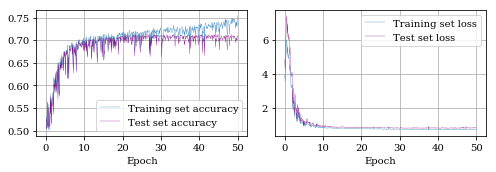

In [6]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
epochs = np.arange(len(b[0])) * 25 * 256 / 70000
fig = plt.figure()
fig.set_size_inches(7, 2.5)
g = fig.add_subplot(1,2,1)
g.grid()
g.plot(epochs, b[0], label='Training set accuracy', lw=0.3)
g.plot(epochs, b[1], label='Test set accuracy', color="purple", lw=0.3)
g.legend(loc='lower right')
plt.xlabel("Epoch")
g = fig.add_subplot(1,2,2)
g.plot(epochs, b[2], label='Training set loss', lw=0.3)
g.plot(epochs, b[3], label='Test set loss', color="purple", lw=0.3)
g.legend(loc='upper right')
g.grid()
plt.xlabel("Epoch")
# plt.plot(b[0])
# plt.plot(b[1])
# plt.grid()
plt.tight_layout()
plt.savefig(graphs_folder + '/paper_lcurve.pdf', format='pdf')
plt.show()

In [23]:
b = load_ld("models/model_formats/rnn_mt_model_log.data", pad=False)

In [25]:
max(b[1])

0.7145809

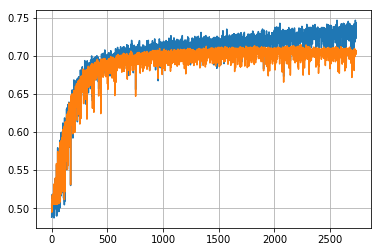

In [34]:
n_iters = int(50 * 70000 / (5 * 256))
plt.plot(b[0][:n_iters])
plt.plot(b[1][:n_iters])
plt.grid()
plt.show()

In [23]:
b = load_ld("models/models/rnn_mt_model_log.data", pad=False)

In [25]:
max(b[1])

0.7145809

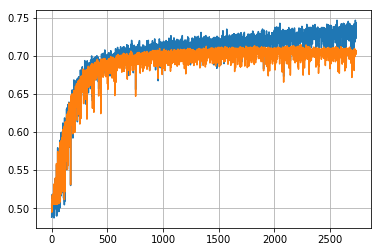

In [34]:
n_iters = int(50 * 70000 / (5 * 256))
plt.plot(b[0][:n_iters])
plt.plot(b[1][:n_iters])
plt.grid()
plt.show()

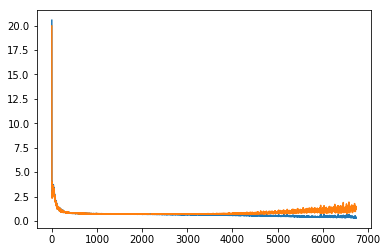

In [26]:
plt.plot(b[2])
plt.plot(b[3])
plt.show()

In [210]:
meta, X, Yc, Yr, Y, meta_labels, X_labels, alpha, beta, X_scales, X_scalesdict, Yr_scales, Yr_scalesdict = load_ld("d_lorb_scaled")
pr_fl("# samples:", X.shape[0])

 2019-11-28 19:25:22 # samples: 87743


In [215]:
np.mean(Y[70000:])

0.4931522290480753

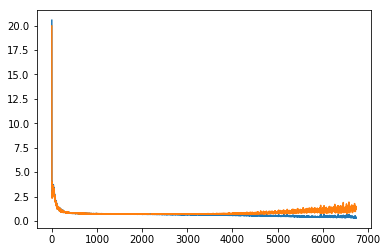

[0.50523055,
 0.49476948,
 0.51052564,
 0.50523055,
 0.50432646,
 0.5122046,
 0.5169831,
 0.50574714,
 0.5053597,
 0.505618,
 0.5075552,
 0.5053597,
 0.50523055,
 0.50665116,
 0.5189203,
 0.51052564,
 0.50523055,
 0.5054888,
 0.505618,
 0.505618,
 0.5051014,
 0.50523055,
 0.50574714,
 0.53196436,
 0.5169831,
 0.50845927,
 0.5053597,
 0.51633734,
 0.5270567,
 0.5174997,
 0.5109131,
 0.51775795,
 0.539455,
 0.53958416,
 0.50523055,
 0.50523055,
 0.5154333,
 0.5208576,
 0.51427096,
 0.5155624,
 0.5246029,
 0.5078135,
 0.5054888,
 0.558569,
 0.55598605,
 0.5053597,
 0.5054888,
 0.5424254,
 0.5351931,
 0.5053597,
 0.50626373,
 0.5466873,
 0.5058763,
 0.521245,
 0.57445437,
 0.50613457,
 0.5060054,
 0.5155624,
 0.5118171,
 0.5079427,
 0.54061735,
 0.51401263,
 0.50716776,
 0.5510784,
 0.55443627,
 0.50613457,
 0.5088467,
 0.53377247,
 0.5700633,
 0.5231822,
 0.51246285,
 0.512592,
 0.58000773,
 0.5078135,
 0.51401263,
 0.5608937,
 0.58659434,
 0.5103965,
 0.5327392,
 0.52189076,
 0.53067285,

In [192]:
plt.plot(a[2])
plt.plot(a[3])
plt.show()
a[1]

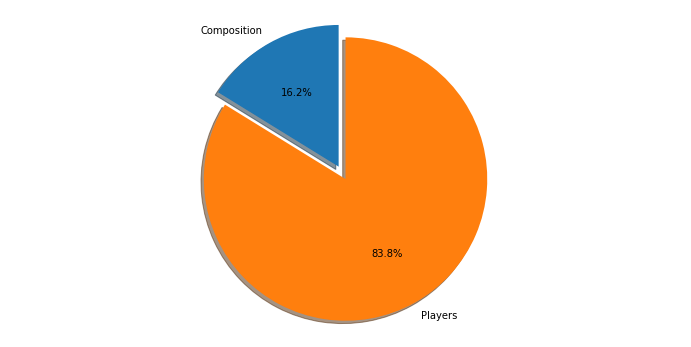

In [15]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Composition', 'Players'
sizes = [2.9, 15]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig1.set_size_inches(12, 6)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(graphs_folder + '/' + "comp_vs_players_pie" + '.pdf', format='pdf')
plt.show()

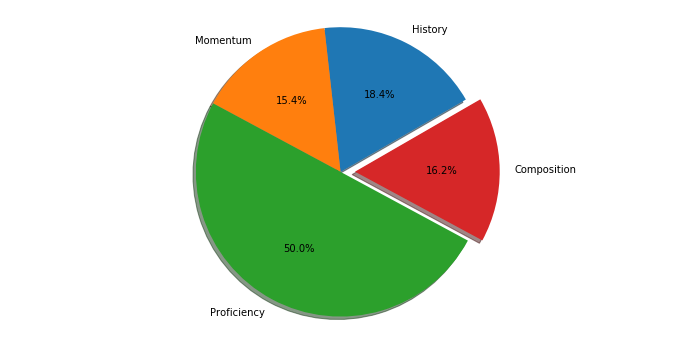

In [17]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'History', 'Momentum', 'Proficiency', 'Composition'
sizes = [3.3, 2.75, 8.94, 2.9, ]
explode = (0, 0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig1.set_size_inches(12, 6)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=30)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(graphs_folder + '/' + "comp_prof_mom_hist" + '.pdf', format='pdf')
plt.show()

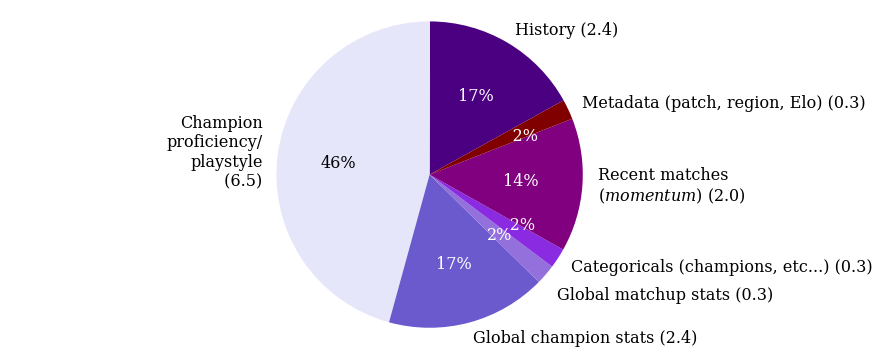

In [24]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['History', 'Champion\nproficiency/\nplaystyle\n', 'Global champion stats', \
         'Global matchup stats', 'Categoricals (champions, etc...)', \
         'Recent matches\n($momentum$)', 'Metadata (patch, region, Elo)']
sizes = [2.4, 6.5, 2.4, 0.3, 0.3, 2.0, 0.3]
for i in range(len(sizes)):
#     labels[i] += ' (?)'
    labels[i] += ' (' + str(sizes[i]) + ')'
# sizes = [3.3, 2.75, 8.94, 0.31, 0.3, 1.97, 0.25]
# explode = (0.08, 0.08, 0.08, 0, 0, 0, 0)
explode = (0, 0, 0, 0.045, 0.09, 0.12, 0.06)

fig1, ax1 = plt.subplots()
fig1.set_size_inches(12, 5)
patches, texts, autotexts = ax1.pie(sizes, labels=labels, #explode=explode,
    colors=["indigo","lavender","slateblue","mediumpurple","blueviolet","purple","maroon"],
    autopct='%1.f%%', shadow=False, startangle=29)
autotexts[0].set_color("white")
# autotexts[1].set_color("white")
autotexts[2].set_color("white")
autotexts[3].set_color("white")
autotexts[4].set_color("white")
autotexts[5].set_color("white")
autotexts[6].set_color("white")
# autotexts[7].set_color("white")
autotexts[-1].set_text("     " + autotexts[-1].get_text())
autotexts[4].set_text("      " + autotexts[4].get_text())
texts[3].set_text("\n" + texts[3].get_text())
[at.set_fontsize(16) for at in autotexts]
[at.set_fontsize(16) for at in texts]
[at.set_fontname("serif") for at in texts]
[at.set_fontname("serif") for at in autotexts]
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(graphs_folder + '/' + "featImps_pie" + '.pdf', format='pdf')
plt.tight_layout()
plt.show()

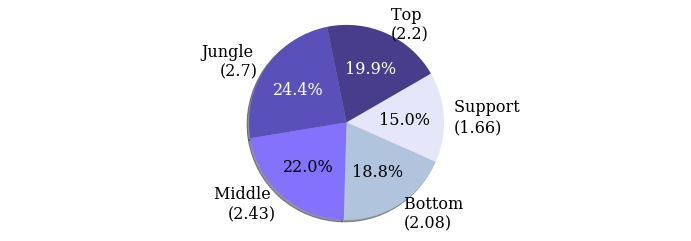

In [15]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Top", "Jungle", "Middle", "Bottom", "Support"]
sizes = [2.2, 2.7, 2.43, 2.08, 1.66]
for i in range(len(sizes)):
    labels[i] += ' \n(' + str(sizes[i]) + ')'
# explode = (0.08, 0.08, 0.08, 0, 0, 0, 0)
# explode = (0, 0, 0, 0.045, 0.09, 0.12, 0.06)

fig1, ax1 = plt.subplots()
fig1.set_size_inches(12, 4)
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
    colors=["darkslateblue","#5a50b9","#8472fc","lightsteelblue","lavender",],
    shadow=True, startangle=30)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
[at.set_fontsize(16) for at in autotexts]
[at.set_fontsize(16) for at in texts]
[at.set_fontname("serif") for at in texts]
[at.set_fontname("serif") for at in autotexts]
autotexts[0].set_color("white")
autotexts[1].set_color("white")
plt.savefig(graphs_folder + '/' + "roleImps_pie" + '.pdf', format='pdf')

plt.show()

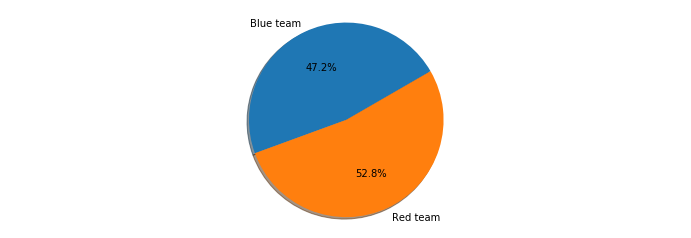

In [128]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = "Blue team", "Red team"
sizes = [6, 6.7]
# explode = (0.08, 0.08, 0.08, 0, 0, 0, 0)
# explode = (0, 0, 0, 0.045, 0.09, 0.12, 0.06)

fig1, ax1 = plt.subplots()
fig1.set_size_inches(12, 4)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=30)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [129]:
X_c_prev_labels_all

['queue',
 'duration',
 'win',
 'champion',
 'team_side',
 'spell_1',
 'spell_2',
 'kills',
 'deaths',
 'assists',
 'creep_score',
 'creep_score_per_second',
 'kill_participation',
 'level',
 'timestamp',
 'time_of_day',
 'pinks_purchased',
 'opgg_champion_recent_wins',
 'opgg_champion_recent_losses',
 'opgg_champion_recent_total_wins',
 'opgg_champion_recent_total_losses',
 'opgg_champion_recent_alltotal_wins',
 'opgg_champion_recent_alltotal_losses',
 'opgg_champion_recent_rank',
 'opgg_champion_recent_mean_rank',
 'opgg_champion_recent_mean_max_rank',
 'opgg_champion_recent_max_rank',
 'opgg_champion_recent_kills',
 'opgg_champion_recent_deaths',
 'opgg_champion_recent_assists',
 'opgg_champion_recent_gold',
 'opgg_champion_recent_creep_score',
 'opgg_champion_recent_damage_dealt',
 'opgg_champion_recent_damage_taken',
 'opgg_champion_recent_double_kills',
 'opgg_champion_recent_triple_kills',
 'opgg_champion_recent_quadra_kills',
 'opgg_champion_recent_max_kills',
 'opgg_champion_r

In [3]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = d_all
X_rec_labels = X_rec_labels[:-1]
save_ld((meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels)), "d_all")

In [1]:
X_rec_labels

NameError: name 'X_rec_labels' is not defined

In [6]:
len([141, 19, 266, 238, 82, 21, 51, 99, 222, 81, 56, 22, 45, 67, 37, 101, 79, 120, 20, 110, 517, 427, 74, 498, 236, 420, 2, 157, 55, 35, 6, 63, 122, 8, 69, 30, 80, 105, 4, 136, 104, 202, 96, 53, 119, 131, 50, 64, 121, 24, 5, 17, 103, 9, 102, 76, 32, 91, 39, 58, 154, 555, 412, 13, 75, 15, 84, 12, 201, 223, 350, 117, 113, 90, 111, 33, 25, 26, 29, 421, 107, 98, 203, 54, 77, 254, 106, 23, 245, 27, 78, 1, 7, 43, 497, 89, 3, 92, 86, 126, 40, 44, 518, 41, 31, 62, 143, 10, 115])

109

In [13]:
np.sum(np.array([[[0,1,0],[0,0,1]], [[0,1,0],[1,0,0]]]), axis=1)

array([[0, 1, 1],
       [1, 1, 0]])

In [45]:
"blah" in locals()

True

In [22]:
np.argsort(np.argsort([5,12,4,6,9]))

array([1, 4, 0, 2, 3], dtype=int64)

In [23]:
np.argsort([5,12,4,6,9])

array([2, 0, 3, 4, 1], dtype=int64)

In [43]:
np.mean([np.array([1.0]), np.array([2.5])])

1.75

In [174]:
np.mean([0.9333333333333333, 0.8529411764705882, 0.8157894736842105, 0.8148148148148148, 0.8571428571428571, ])

0.8548043310891608

In [172]:
pro_model_nsqo, pro_scores_nsqo = load_ld(pro_model_fn + '_nsqo')       # Pro model
pro_model_sqo, pro_scores_sqo = load_ld(pro_model_fn + '_sqo')          # Pro model when we don't have pro stats
pr(("Pro model accuracy (nsqo):", pro_scores_nsqo))
pr(("Pro model accuracy  (sqo):", pro_scores_sqo))

(   'Pro model accuracy (nsqo):',
    {   'CBLoL': 0.9333333333333333,
        'LCK': 0.8529411764705882,
        'LCS': 0.8157894736842105,
        'LEC': 0.8148148148148148,
        'LMS': 0.8571428571428571,
        'MSI': 0.8095238095238095})
(   'Pro model accuracy  (sqo):',
    {   'CBLoL': 1.0,
        'LCK': 0.8382352941176471,
        'LCS': 0.7368421052631579,
        'LEC': 0.8148148148148148,
        'LMS': 0.8571428571428571,
        'MSI': 0.7936507936507936})


In [48]:
np.vstack([np.tile(4, 3), np.tile(4, 3)])

array([[4, 4, 4],
       [4, 4, 4]])

In [283]:
patches_all[0]

'9.17'

In [280]:
3/np.array([0.0, 2])

c:\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([inf, 1.5])

In [27]:
d, D, X_a, X, Y, X_groups, scalers, plist, llist, player_role_perfs, role_league_perf_cache = load_ld("pro_data")

In [28]:
pca_res = load_ld("pca_results")

In [88]:
leag_idx = [i for i in range(len(D)) if pro_leagues[D[i]["league"]] == "LEC"]
# leag_idx = range(len(D))
len(leag_idx)

59

In [89]:
pca_rs = pca_res["nsqo"]
fset_res = []
Y_leag = Y[leag_idx]
for i in pca_rs:
#     if i < 25: continue
#     if i < 45: continue
#     if i > 120: continue  # This case is never actually triggered, but may be needed if the dataset changes
#     if i > 100: continue   # sqo case
#     if i > 190: continue   # sqo case
#     if i > 110: continue   # LEC case

    if pca_rs[i] == []:
        print(i)
        continue
    pca_r = [np.mean([ps[leag_idx] == Y_leag for ps in pca_rs[i][::-1][j]]) for j in range(
        len(pca_rs[i])) if (j/len(pca_rs[i])) < 1.0]
#     best_i = np.argmax(pca_r)
    min_i = int(i * 0.3)
#     best_i = min_i + np.argmax(pca_r[min_i:])
    best_i = min_i + np.argmax(pca_r[min_i:int(i * 0.95) + 1])
    best_acc = pca_r[best_i]
    fset_res.append((best_acc, i, best_i))
fset_res.sort()

1


In [90]:
max(pca_rs.keys())

89

In [91]:
fset_res[::-1]

[(0.8991525423728813, 58, 21),
 (0.8983050847457628, 59, 22),
 (0.8966101694915254, 57, 30),
 (0.8966101694915254, 56, 28),
 (0.8957627118644068, 61, 25),
 (0.8932203389830509, 60, 26),
 (0.8915254237288136, 68, 27),
 (0.8906779661016949, 64, 21),
 (0.8898305084745762, 67, 26),
 (0.8889830508474577, 62, 20),
 (0.888135593220339, 66, 24),
 (0.8864406779661017, 69, 26),
 (0.8864406779661017, 65, 25),
 (0.8847457627118644, 63, 19),
 (0.8771186440677966, 33, 13),
 (0.8745762711864407, 42, 16),
 (0.8720338983050847, 34, 14),
 (0.8711864406779661, 74, 26),
 (0.8703389830508474, 28, 12),
 (0.8694915254237288, 82, 25),
 (0.8694915254237288, 73, 23),
 (0.8686440677966102, 75, 27),
 (0.8686440677966102, 27, 11),
 (0.8677966101694915, 78, 26),
 (0.8677966101694915, 53, 25),
 (0.8669491525423729, 79, 25),
 (0.8669491525423729, 77, 25),
 (0.8661016949152542, 76, 24),
 (0.8661016949152542, 55, 28),
 (0.8652542372881356, 81, 25),
 (0.8652542372881356, 54, 26),
 (0.8635593220338983, 43, 16),
 (0.86271

7 0.8627118644067797


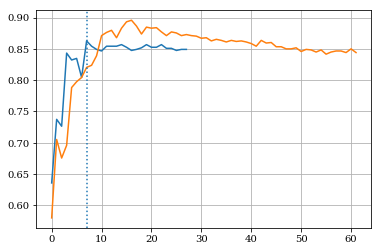

In [118]:
pca_r = [np.mean([ps[leag_idx] == Y[leag_idx] for ps in preds_set]) for preds_set in pca_rs[29][::-1]]
pca_r2 = [np.mean([ps[leag_idx] == Y[leag_idx] for ps in preds_set]) for preds_set in pca_rs[63][::-1]]
pca_x = list(range(len(pca_r)))
pca_x.sort()
pca_y = pca_r
plt.plot(pca_x, pca_y)
plt.plot(list(range(len(pca_r2))), pca_r2)
# best_i = 10 + ((len(pca_r) - 11) - np.argmax(pca_r[10:][::-1]))
best_i = np.argmax(pca_r)
print(best_i, pca_r[best_i])
plt.axvline(x=best_i, ls=':')
plt.grid()

26 0.8111111111111111


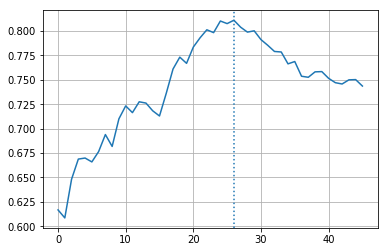

In [70]:
pca_x = list(range(len(pca_r)))
pca_x.sort()
pca_y = pca_r
plt.plot(pca_x, pca_y)
# best_i = 10 + ((len(pca_r) - 11) - np.argmax(pca_r[10:][::-1]))
best_i = np.argmax(pca_r)
print(best_i, pca_r[best_i])
plt.axvline(x=best_i, ls=':')
plt.grid()

In [481]:
patch_s2n("9.1")

9.01

In [137]:
money = 350
money -= 0.21 * money
money += money * 0.25 * (9/10)
money += money * 0.33 * (1/1)
money += money * 0.23 * (1/1)
money += money * 0.25 * (1/2)
money += money * 0.16 * (1/2)
money += money * 0.22 * (1/2)
money -= money * 0.1
money += money * 0.15 * (3/2)
money

823.8835499388342

In [62]:
selector = load_ld("pro_model_sqo_selector")

In [65]:
sqlabels = [l for l in X_groups if '_'.join(l.split('_')[1:]) not in pro_full_player_labels]
[sqlabels[i] for i in selector.subsets_[152]["feature_idx"]]

['top_chgg_eloavg_champion_play_rate',
 'top_chgg_eloavg_champion_total_heal',
 'top_chgg_eloavg_champion_duration_15_to_20_win_rate',
 'top_chgg_eloavg_champion_duration_30_to_35_win_rate',
 'top_opgg_champion_avg_losses',
 'top_opgg_champion_avg_alltotal_wins',
 'top_opgg_champion_avg_creep_score',
 'top_1ravg_win',
 'top_1ravg_opgg_champion_recent_wins',
 'top_1ravg_opgg_eloavg_champion_today_win_rate',
 'top_2ravg_opgg_champion_recent_mean_rank',
 'top_2ravg_assists_/_opgg_champion_recent_assists',
 'top_4ravg_deaths',
 'top_8ravg_kills',
 'top_8ravg_opgg_champion_recent_losses',
 'top_8ravg_kills_/_chgg_eloavg_champion_kills',
 'top_20ravg_creep_score',
 'top_opgg_champion_avg_bayes_win_rate',
 'top_1ravg_opgg_champion_recent_bayes_win_rate',
 'top_2ravg_opgg_champion_recent_bayes_win_rate',
 'top_8ravg_opgg_champion_recent_bayes_win_rate',
 'top_opgg_champion_avg_alltotal_games',
 'top_opgg_champion_recent_assists_/_chgg_eloavg_champion_assists',
 'top_opgg_champion_recent_alltot

In [292]:
[X_groups[i] for i in selector.subsets_[151]["feature_idx"]]

['sq_prediction',
 'top_chgg_eloavg_champion_play_rate',
 'top_chgg_eloavg_champion_wards_placed',
 'top_chgg_eloavg_champion_duration_0_to_15_win_rate',
 'top_elodeviation',
 'top_opgg_champion_all_Assassin_losses',
 'top_opgg_champion_avg_losses',
 'top_1ravg_deaths',
 'top_1ravg_opgg_eloavg_champion_today_win_rate',
 'top_2ravg_assists',
 'top_2ravg_opgg_champion_recent_wins',
 'top_2ravg_opgg_eloavg_champion_today_win_rate',
 'top_4ravg_duration',
 'top_4ravg_deaths',
 'top_4ravg_pinks_purchased',
 'top_4ravg_deaths_/_opgg_champion_recent_deaths',
 'top_8ravg_opgg_champion_recent_losses',
 'top_20ravg_chgg_eloavg_champion_win_rate',
 'top_opgg_champion_avg_alltotal_games',
 'top_opgg_champion_recent_gold_/_opgg_eloavg_champion_today_gold',
 'top_opgg_champion_recent_wins',
 'top_opgg_champion_recent_games',
 'jungle_chgg_eloavg_champion_duration_0_to_15_win_rate',
 'jungle_chgg_eloavg_champion_duration_25_to_30_win_rate',
 'jungle_elo',
 'jungle_opgg_champion_all_Fighter_losses',
 

TypeError: float() argument must be a string or a number, not 'dict'

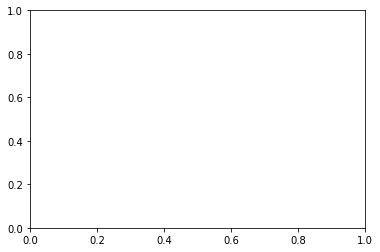

In [7]:
plt.plot(pca_res)